In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import jax
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import functools
import os
import urllib.request
import e3x
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax

# Disable future warnings.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[cuda(id=0)]
gpu
[cuda(id=0)]


In [2]:
jax.default_backend()
jax.devices()

[cuda(id=0)]

In [3]:
dataset = np.load("../data/mulitpoles10000.npz")

In [17]:
dict(dataset).keys()

dict_keys(['R', 'Z', 'N', 'F', 'mono', 'dip', 'quad'])

In [4]:
a = np.nonzero(dataset["mono"].sum(axis=1).flatten())

In [5]:
zeros = np.where(np.all(dataset["mono"] == 0, axis=1))[0]

In [6]:
dataset["mono"].shape

(10000, 60, 1)

In [7]:
# Total indices range
total_indices = np.arange(dataset["mono"].shape[0])

# Find indices of non-zero arrays
nonzeros_indices = np.setdiff1d(total_indices, zeros)

print(nonzeros_indices)
print(len(nonzeros_indices))

[   0    1    2 ... 9997 9998 9999]
10000


In [8]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)

In [9]:
def prepare_datasets(key, num_train, num_valid, filename="mulitpoles766000.npz"):
  # Load the dataset.
  dataset = np.load(filename)
    
  for k,v in dataset.items():
      print(k, v.shape)

  num_data = len(dataset["mono"])
  nonzeros = np.where(np.all(dataset["mono"] == 0, axis=1))[0]
  total_indices = np.arange(num_data)
  # Find indices of non-zero arrays
  nonzeros = np.setdiff1d(total_indices, zeros)
  
  dataF =   dataset['F'][nonzeros]
  dataR =   dataset['R'][nonzeros]
  dataZ =   dataset['Z'][nonzeros]
  dataMono =   dataset['mono'][nonzeros]
  dataDip = dataset['dip'][nonzeros]
  # dataset['F'] =   dataset['F'][nonzeros]
    
  # Make sure that the dataset contains enough entries.
  num_data = len(dataR)
  print(num_data)
  num_draw = num_train + num_valid
  if num_draw > num_data:
    raise RuntimeError(
      f'datasets only contains {num_data} points, requested num_train={num_train}, num_valid={num_valid}')

  # Randomly draw train and validation sets from dataset.
  choice = np.asarray(jax.random.choice(key, num_data, shape=(num_draw,), replace=False))
  train_choice = choice[:num_train]
  valid_choice = choice[num_train:]

  # atomic_numbers = jnp.tile(dataset['z'], num_data).reshape((num_data, len(dataset["z"])))
  atomic_numbers = dataZ
    
  # Determine mean energy of the training set.
  # mean_energy = np.mean(dataset['E'][train_choice])  # ~ -97000
  mean_energy = 0

  # Collect and return train and validation sets.
  train_data = dict(
    # energy=jnp.asarray(dataset['E'][train_choice] - mean_energy),
    # forces=jnp.asarray(dataF[train_choice]),
    atomic_numbers=jnp.asarray(atomic_numbers[train_choice]),
    positions=jnp.asarray(dataR[train_choice]),
    mono=jnp.asarray(dataMono[train_choice]),
    dipo=jnp.asarray(dataDip[train_choice]),
  )
  valid_data = dict(
    # energy=jnp.asarray(dataset['E'][valid_choice] - mean_energy),
    # forces=jnp.asarray(dataF[valid_choice]),
    atomic_numbers=jnp.asarray(atomic_numbers[valid_choice]),
    positions=jnp.asarray(dataR[valid_choice]),
    mono=jnp.asarray(dataMono[valid_choice]),
    dipo=jnp.asarray(dataDip[valid_choice]),
  )
  print("...")
  print("...")
  for k,v in train_data.items():
      print(k, v.shape)
  print("...")
  for k,v in valid_data.items():
      print(k, v.shape)
      
  return train_data, valid_data, mean_energy

In [62]:
2**19

524288

In [63]:
train_data, valid_data, mean_energy = prepare_datasets(data_key, 2**19, 320, 
                                                       filename="../data/mulitpoles766000.npz")

R (766000, 60, 3)
Z (766000, 60)
N (766000,)
F (766000, 60, 3)
mono (766000, 60, 1)
dip (766000, 60, 3)
quad (766000, 60, 6)
766000
...
...
atomic_numbers (524288, 60)
positions (524288, 60, 3)
mono (524288, 60, 1)
dipo (524288, 60, 3)
...
atomic_numbers (320, 60)
positions (320, 60, 3)
mono (320, 60, 1)
dipo (320, 60, 3)


In [64]:


class MessagePassingModel(nn.Module):
  features: int = 32
  max_degree: int = 2
  num_iterations: int = 3
  num_basis_functions: int = 8
  cutoff: float = 5.0
  max_atomic_number: int = 17  # This is overkill for most applications.


  def mono(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size):
    # 1. Calculate displacement vectors.
    positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
    positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
    displacements = positions_src - positions_dst  # Shape (num_pairs, 3).

    # 2. Expand displacement vectors in basis functions.
    basis = e3x.nn.basis(  # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
      displacements,
      num=self.num_basis_functions,
      max_degree=self.max_degree,
      radial_fn=e3x.nn.reciprocal_bernstein,
      cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff)
    )

    # 3. Embed atomic numbers in feature space, x has shape (num_atoms, 1, 1, features).
    x = e3x.nn.Embed(num_embeddings=self.max_atomic_number+1, features=self.features)(atomic_numbers)

    # 4. Perform iterations (message-passing + atom-wise refinement).
    for i in range(self.num_iterations):
      # Message-pass.
      if i == self.num_iterations-1:  # Final iteration.
        # Since we will only use scalar features after the final message-pass, we do not want to produce non-scalar
        # features for efficiency reasons.
        y = e3x.nn.MessagePass(max_degree=max_degree, include_pseudotensors=False)(x, basis, dst_idx=dst_idx, src_idx=src_idx)
        # After the final message pass, we can safely throw away all non-scalar features.
        x = e3x.nn.change_max_degree_or_type(x, max_degree=max_degree, include_pseudotensors=False)
      else:
        # In intermediate iterations, the message-pass should consider all possible coupling paths.
        y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)
          
      y = e3x.nn.add(x, y)
      # Atom-wise refinement MLP.
      y = e3x.nn.Dense(self.features)(y)
      y = e3x.nn.silu(y)
      y = e3x.nn.Dense(self.features, kernel_init=jax.nn.initializers.zeros)(y)
      # Residual connection.
      x = e3x.nn.add(x, y)

    # 5. Predict atomic monopoles with an ordinary dense layer.
    element_bias = self.param('element_bias', lambda rng, shape: jnp.zeros(shape), (self.max_atomic_number+1))
    atomic_mono = nn.Dense(1, use_bias=False, kernel_init=jax.nn.initializers.zeros)(x[:,0,0])  # (..., Natoms, 1, 1, 1)
    atomic_mono = jnp.squeeze(atomic_mono, axis=(-1))  # Squeeze last 3 dimensions.
    atomic_mono += element_bias[atomic_numbers]

    atomic_dipo = e3x.nn.TensorDense(  
        features=self.features,
        max_degree=1, 
        include_pseudotensors=False,
    )(x)
    atomic_dipo = e3x.nn.silu(atomic_dipo)
    atomic_dipo = jnp.sum(atomic_dipo, axis=-1)[:,0,1:4]

    return atomic_mono, atomic_dipo


  @nn.compact
  def __call__(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments=None, batch_size=None):
    if batch_segments is None:
      batch_segments = jnp.zeros_like(atomic_numbers)
      batch_size = 1

    return self.mono(atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size)

In [65]:
def prepare_batches(key, data, batch_size):
  # Determine the number of training steps per epoch.
  data_size = len(data['mono'])
  steps_per_epoch = data_size//batch_size

  # Draw random permutations for fetching batches from the train data.
  perms = jax.random.permutation(key, data_size)
  perms = perms[:steps_per_epoch * batch_size]  # Skip the last batch (if incomplete).
  perms = perms.reshape((steps_per_epoch, batch_size))

  # Prepare entries that are identical for each batch.
  num_atoms = len(data['atomic_numbers'][0])
  batch_segments = jnp.repeat(jnp.arange(batch_size), num_atoms)
  # atomic_numbers = jnp.tile(data['atomic_numbers'], batch_size)
  offsets = jnp.arange(batch_size) * num_atoms
  dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(num_atoms)
  dst_idx = (dst_idx + offsets[:, None]).reshape(-1)
  src_idx = (src_idx + offsets[:, None]).reshape(-1)

  # Assemble and return batches.
  return [
    dict(
        # energy=data['energy'][perm],
        # forces=data['forces'][perm].reshape(-1, 3),
        mono=data["mono"][perm].reshape(-1),
        dipo=data['dipo'][perm].reshape(-1, 3),
        atomic_numbers=data["atomic_numbers"][perm].reshape(-1),
        positions=data['positions'][perm].reshape(-1, 3),
        dst_idx=dst_idx,
        src_idx=src_idx,
        batch_segments = batch_segments,
    )
    for perm in perms
  ]

In [66]:
def mean_squared_loss(mono_prediction, mono_target, dipo_prediction, dipo_target, batch_size):
  nonzero = jnp.nonzero(mono_target, size=batch_size*60)
  mono_mse = jnp.mean(optax.l2_loss(mono_prediction[nonzero], mono_target[nonzero]))
  dipo_mse = jnp.mean(optax.l2_loss(dipo_prediction[nonzero], dipo_target[nonzero]))
  return mono_mse + dipo_mse * 10.0


def mean_absolute_error(prediction, target,batch_size):
  nonzero = jnp.nonzero(target, size=batch_size*60)
  return jnp.mean(jnp.abs(prediction[nonzero] - target[nonzero]))

In [67]:
@functools.partial(jax.jit, static_argnames=('model_apply', 'optimizer_update', 'batch_size'))
def train_step(model_apply, optimizer_update, batch, batch_size, opt_state, params):
    
  def loss_fn(params):
    mono, dipo = model_apply(
      params,
      atomic_numbers=batch['atomic_numbers'],
      positions=batch['positions'],
      dst_idx=batch['dst_idx'],
      src_idx=batch['src_idx'],
      batch_segments=batch['batch_segments'],
      batch_size=batch_size
    )
    loss = mean_squared_loss(
      mono_prediction=mono,
      mono_target=batch['mono'],
      dipo_prediction=dipo,
      dipo_target=batch['dipo'],
      batch_size = batch_size
    )
    return loss, (mono, dipo)
      
  (loss, (mono, dipo)), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)
  updates, opt_state = optimizer_update(grad, opt_state, params)
  params = optax.apply_updates(params, updates)
  mono_mae = mean_absolute_error(mono, batch['mono'], batch_size)
  dipo_mae = mean_absolute_error(dipo, batch['dipo'], batch_size)
  return params, opt_state, loss, mono_mae, dipo_mae


@functools.partial(jax.jit, static_argnames=('model_apply', 'batch_size'))
def eval_step(model_apply, batch, batch_size, params):

  mono, dipo = model_apply(
      params,
      atomic_numbers=batch['atomic_numbers'],
      positions=batch['positions'],
      dst_idx=batch['dst_idx'],
      src_idx=batch['src_idx'],
      batch_segments=batch['batch_segments'],
      batch_size=batch_size
    )
  loss = mean_squared_loss(
      mono_prediction=mono,
      mono_target=batch['mono'],
      batch_size=batch_size,
      dipo_prediction=dipo,
      dipo_target=batch['dipo'],
    )
  mono_mae = mean_absolute_error(mono, batch['mono'], batch_size)
  dipo_mae = mean_absolute_error(dipo, batch['dipo'], batch_size)
  return loss, mono_mae, dipo_mae


def train_model(key, model, train_data, valid_data, num_epochs, learning_rate, batch_size,
               restart=None):
  # Initialize model parameters and optimizer state.
  key, init_key = jax.random.split(key)
  optimizer = optax.adam(learning_rate)
  dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(train_data['atomic_numbers'][0]))
  params = model.init(init_key,
    atomic_numbers=train_data['atomic_numbers'][0],
    positions=train_data['positions'][0],
    dst_idx=dst_idx,
    src_idx=src_idx,
  )
  if restart is not None:
      params = restart
  opt_state = optimizer.init(params)

  print("Preparaing batches")
  print("..................")
  # Batches for the validation set need to be prepared only once.
  key, shuffle_key = jax.random.split(key)
  valid_batches = prepare_batches(shuffle_key, valid_data, batch_size)

  # Train for 'num_epochs' epochs.
  for epoch in range(1, num_epochs + 1):
    # Prepare batches.
    key, shuffle_key = jax.random.split(key)
    train_batches = prepare_batches(shuffle_key, train_data, batch_size)

    # Loop over train batches.
    train_loss = 0.0
    train_mono_mae = 0.0
    train_dipo_mae = 0.0
    for i, batch in enumerate(train_batches):
      params, opt_state, loss, mono_mae, dipo_mae = train_step(
        model_apply=model.apply,
        optimizer_update=optimizer.update,
        batch=batch,
        batch_size=batch_size,
        opt_state=opt_state,
        params=params
      )
      train_loss += (loss - train_loss)/(i+1)
      train_mono_mae += (mono_mae - train_mono_mae)/(i+1)
      train_dipo_mae += (dipo_mae - train_dipo_mae)/(i+1)

    # Evaluate on validation set.
    valid_loss = 0.0
    valid_mono_mae = 0.0
    valid_dipo_mae = 0.0
    for i, batch in enumerate(valid_batches):
      loss, mono_mae, dipo_mae = eval_step(
        model_apply=model.apply,
        batch=batch,
        batch_size=batch_size,
        params=params
      )
      valid_loss += (loss - valid_loss)/(i+1)
      valid_mono_mae += (mono_mae - valid_mono_mae)/(i+1)
      valid_dipo_mae += (dipo_mae - valid_dipo_mae)/(i+1)
        
    # Print progress.
    print(f"epoch: {epoch: 3d}                    train:   valid:")
    print(f"    loss [a.u.]             {train_loss : 8.3f} {valid_loss : 8.3f}")
    print(f"    mono mae [kcal/mol]   {train_mono_mae: 8.3f} {valid_mono_mae: 8.3f}")
    print(f"    dipo mae [kcal/mol]   {train_dipo_mae: 8.3f} {valid_dipo_mae: 8.3f}")

  # Return final model parameters.
  return params

In [68]:
# Model hyperparameters.
features = 16
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 5.0

# Training hyperparameters.
# num_valid = 1000
# num_train = 10000 - num_valid
num_epochs = 50
learning_rate = 0.0001
batch_size = 32

In [69]:
jax.default_backend()
jax.devices()


[cuda(id=0)]

In [20]:
# Create and train model.
message_passing_model = MessagePassingModel(
  features=features,
  max_degree=max_degree,
  num_iterations=num_iterations,
  num_basis_functions=num_basis_functions,
  cutoff=cutoff,
)

In [21]:
params = train_model(
  key=train_key,
  model=message_passing_model,
  train_data=train_data,
  valid_data=valid_data,
  num_epochs=num_epochs,
  learning_rate=learning_rate,
  batch_size=batch_size,
)

Preparaing batches
..................
epoch:   1                    train:   valid:
    loss [a.u.]                0.076    0.060
    mono mae [kcal/mol]      0.311    0.266
    dipo mae [kcal/mol]      0.018    0.018
epoch:   2                    train:   valid:
    loss [a.u.]                0.057    0.046
    mono mae [kcal/mol]      0.253    0.213
    dipo mae [kcal/mol]      0.017    0.016
epoch:   3                    train:   valid:
    loss [a.u.]                0.047    0.040
    mono mae [kcal/mol]      0.215    0.188
    dipo mae [kcal/mol]      0.016    0.016
epoch:   4                    train:   valid:
    loss [a.u.]                0.040    0.035
    mono mae [kcal/mol]      0.190    0.170
    dipo mae [kcal/mol]      0.016    0.016
epoch:   5                    train:   valid:
    loss [a.u.]                0.034    0.030
    mono mae [kcal/mol]      0.174    0.161
    dipo mae [kcal/mol]      0.015    0.015
epoch:   6                    train:   valid:
    loss [a.u.] 

In [22]:
import pickle
# open a file, where you ant to store the data
with open('dipo_mono_params.pkl', 'wb') as file:
    pickle.dump(params, file)

In [ ]:
params = train_model(
  key=train_key,
  model=message_passing_model,
  train_data=train_data,
  valid_data=valid_data,
  num_epochs=10,
  learning_rate=learning_rate,
  batch_size=batch_size,
  restart=params,
)

Preparaing batches
..................
epoch:   1                    train:   valid:
    loss [a.u.]                0.003    0.002
    mono mae [kcal/mol]      0.043    0.035
    dipo mae [kcal/mol]      0.007    0.006


In [ ]:
import pickle
# open a file, where you ant to store the data
with open('dipo_mono_params.pkl', 'wb') as file:
    pickle.dump(params, file)

In [47]:
# params["params"]

def count_shape(array):
    ans = 1
    for shape in array.shape:
        ans *= shape
    return ans

def count_parameters(d):
    if not isinstance(d, dict):  # Base case: not a dictionary
        return 0
    count = 0
    for key, value in d.items():
        if isinstance(value, dict):
            print(key)
            count += count_parameters(value)  # Recursive call if value is a dictionary
        else:
            print(value.shape, count_shape(value))
            count += count_shape(value)  # Count the parameter if it's not a dictionary
    return count

count_parameters(params)

params
Dense_0
0+
(16,) 16
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
Dense_1
0+
(16,) 16
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
Dense_2
0+
(16,) 16
(16, 16) 256
0-
(16, 16) 256
1+
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
2-
(16, 16) 256
Dense_3
0+
(16,) 16
(16, 16) 256
0-
(16, 16) 256
1+
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
2-
(16, 16) 256
Dense_4
0+
(16,) 16
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
Dense_5
0+
(16,) 16
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
Dense_6
(16, 1) 16
Embed_0
(18, 1, 1, 16) 288
MessagePass_0
filter
0+
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
tensor
(1, 3, 1, 1, 1, 3, 16) 144
MessagePass_1
filter
0+
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
tensor
(1, 3, 1, 3, 2, 3, 16) 864
MessagePass_2
filter
0+
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
tensor
(1, 3, 2, 3, 1, 3, 16) 864
TensorDense_0
dense
0+
(32,) 32
(16, 32) 512
1-
(16, 32) 512
2+
(16, 32) 512
tensor
(1, 3, 1, 3, 1, 2, 16) 288
(18,) 18


12594

In [48]:
# valid_data

In [49]:
valid_batches = prepare_batches(data_key, valid_data, 100)

In [50]:
batch = valid_batches[0]
mono, dipo = message_passing_model.apply(
    params,
    atomic_numbers=batch['atomic_numbers'],
    positions=batch['positions'],
    dst_idx=batch['dst_idx'],
    src_idx=batch['src_idx'],
    batch_segments=batch['batch_segments'],
    batch_size=len(valid_data["atomic_numbers"])
)

In [51]:
nonzeros = jnp.nonzero(batch["mono"])

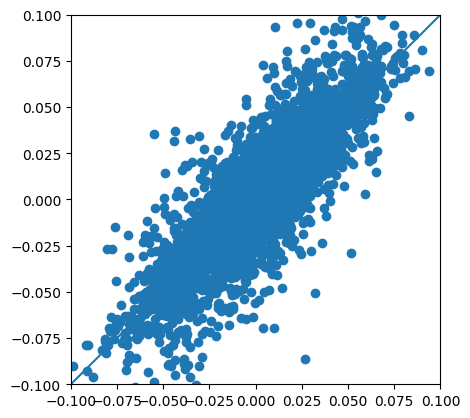

In [52]:
import matplotlib.pyplot as plt
# for i in range(10):
#     plt.scatter(batch_gt[i], patch_pred[i])
plt.scatter(dipo[nonzeros], batch["dipo"][nonzeros])
plt.plot([-1,1],[-1,1])
plt.xlim(-.1,.1)
plt.ylim(-.1,.1)
ax = plt.gca()
ax.set_aspect("equal")

In [53]:
for i in range(10):
    print(dipo[nonzeros][i], "\t\t", batch["dipo"][nonzeros][i])

[-0.01391862  0.01276062  0.00163519] 		 [-0.01152548  0.02594237 -0.00064136]
[0.03399265 0.02324743 0.00793063] 		 [0.0546661  0.02994877 0.01163131]
[-0.05463618 -0.01957258 -0.00879691] 		 [-0.00439058 -0.01236105 -0.00192938]
[0.03811539 0.03001646 0.00975946] 		 [0.0403434  0.02872955 0.00935162]
[-0.0244843  -0.01396899 -0.00467729] 		 [-0.03784621 -0.04116521 -0.01219647]
[ 0.01425597 -0.02540948 -0.00417713] 		 [ 0.01260076 -0.04291096 -0.00975009]
[ 0.00952374 -0.01168921  0.00162902] 		 [ 0.03841402 -0.01560755 -0.00377197]
[-0.04363652  0.00754026 -0.00160085] 		 [-0.05187734  0.00516741 -0.00339097]
[-0.01459709  0.05624713  0.01477748] 		 [-0.02952331  0.04074927  0.00860124]
[ 0.03783814 -0.00519801 -0.00082912] 		 [ 0.05979224 -0.00202199 -0.00228604]


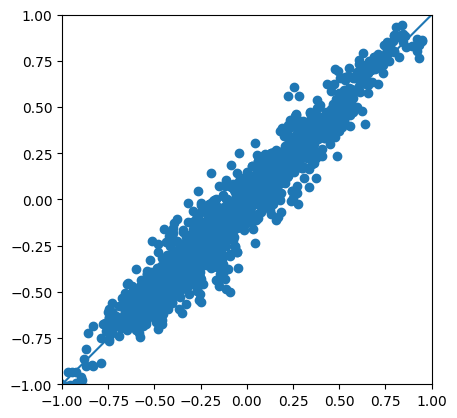

In [54]:
import matplotlib.pyplot as plt
# for i in range(10):
#     plt.scatter(batch_gt[i], patch_pred[i])
plt.scatter(mono[nonzeros], batch["mono"][nonzeros])
plt.plot([-1,1],[-1,1])
plt.xlim(-1,1)
plt.ylim(-1,1)
ax = plt.gca()
ax.set_aspect("equal")

In [31]:
key, rotation_key = jax.random.split(data_key)
rotation = e3x.so3.random_rotation(rotation_key)

In [32]:
rotation

Array([[ 0.05268008,  0.32747042, -0.9433917 ],
       [ 0.9180192 , -0.38768542, -0.08331031],
       [-0.3930209 , -0.8616629 , -0.3210473 ]], dtype=float32)

In [33]:
batch = valid_batches[0]
mono_rot, dipo_rot = message_passing_model.apply(
    params,
    atomic_numbers=batch['atomic_numbers'],
    positions=batch['positions']@rotation,
    dst_idx=batch['dst_idx'],
    src_idx=batch['src_idx'],
    batch_segments=batch['batch_segments'],
    batch_size=len(valid_data["atomic_numbers"])
)

In [34]:
nonzeros = jnp.nonzero(batch["mono"])

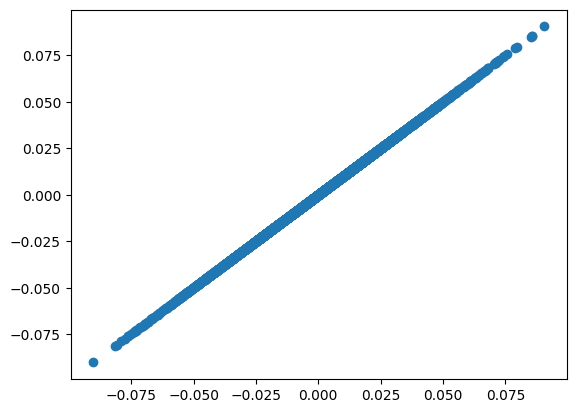

In [35]:
plt.scatter(dipo[nonzeros]@rotation, dipo_rot[nonzeros])

In [45]:
# mean_squared_loss(mono, batch["mono"], 10)

In [46]:
# mean_absolute_error(mono, batch["mono"], 10)